### Testing out PIL image library with torchvision for working with the images from the folder
This notebook tests loading of the data from the dataset and using that data to train a deep learning model

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt
import numpy as np
from alien_dataset import AlienDataset, clean_ben10label_name
from aliendataset_transforms import cleaning_and_randomization_transforms


now that we have imported the required libraries, we can now load the dataset with the dataloaders and test visualizing them with pytorch

In [2]:
DATASET_PATH = "/Users/kosisochukwuasuzu/Developer/deeplearning-reference/projects/alienclassifier/results"

In [3]:
full_dataset = AlienDataset(
    root_dir=DATASET_PATH,
    transform=cleaning_and_randomization_transforms,
    clean_label_name=clean_ben10label_name
)

Loaded 608 images from 10 classes
Classes: [' ghostfreak', ' greymatter', ' ripjaws', ' diamondhead', ' fourarms', ' heatblast', ' stinkfly', ' upgrade', ' wildmutt', ' xlr8']


In [4]:
total_size = len(full_dataset)
print(f"**** total number of images in the dataset: {total_size} ****")

train_size = int(math.floor(0.7 * total_size))
print(f"**** train size: {train_size} ****")
val_size = int(math.floor(0.1 * total_size))
print(f"**** val size: {val_size} ****")
test_size = int(math.floor(0.2 * total_size))
print(f"**** test size: {test_size} ****")

remainder = (total_size) - (train_size + val_size + test_size)
print(f"**** remainder: {remainder} ****")
train_size = train_size + remainder
print(f"**** train size: {train_size} ****")

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

**** total number of images in the dataset: 608 ****
**** train size: 425 ****
**** val size: 60 ****
**** test size: 121 ****
**** remainder: 2 ****
**** train size: 427 ****


In [5]:
full_dataset.classes

[' ghostfreak',
 ' greymatter',
 ' ripjaws',
 ' diamondhead',
 ' fourarms',
 ' heatblast',
 ' stinkfly',
 ' upgrade',
 ' wildmutt',
 ' xlr8']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8556864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.0648367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].


torch.Size([3, 128, 128])


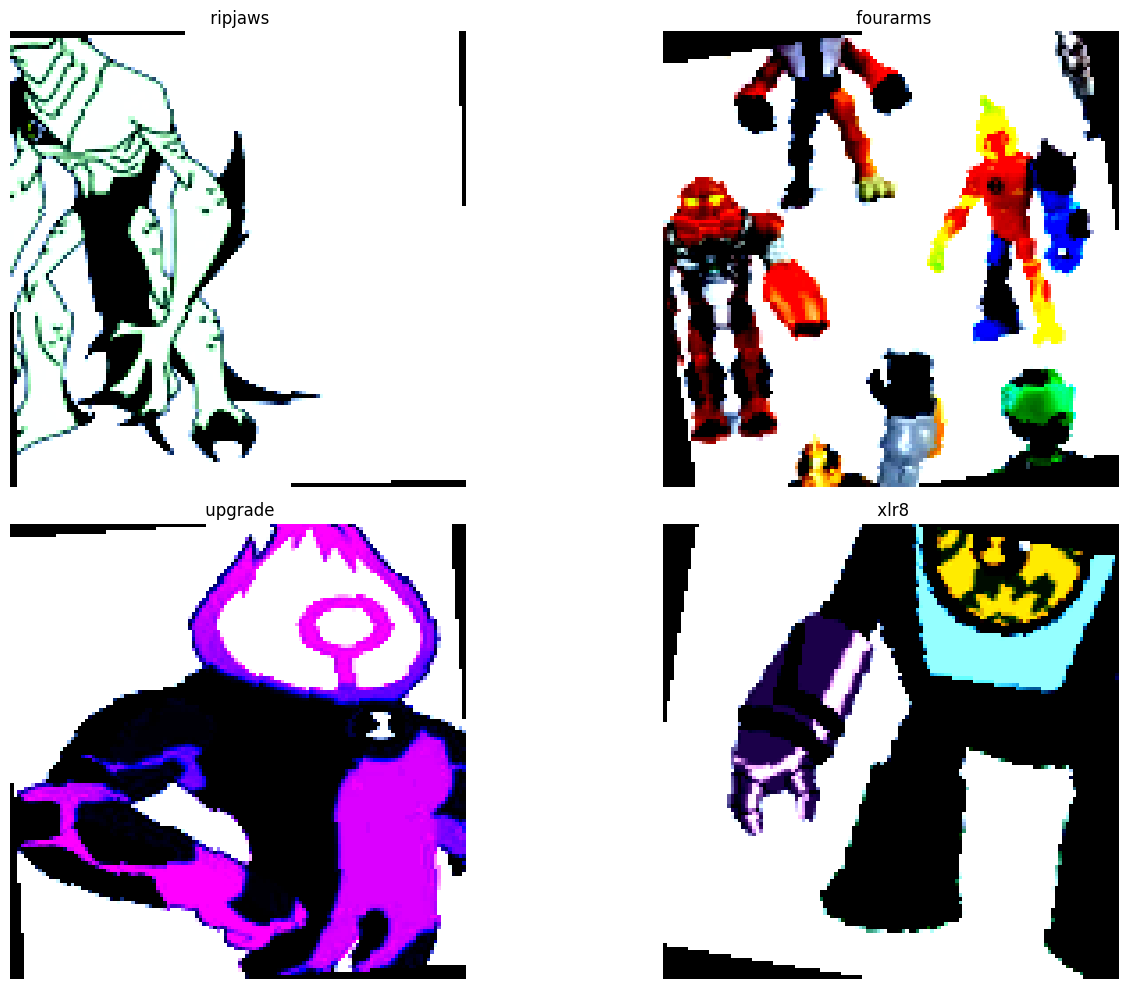

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# visualize the first 10 images in the dataset
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    print(train_dataset[i][0].shape)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(full_dataset.classes[train_dataset[i][1]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
images, labels = next(iter(train_loader))
print(f"**** images shape: {images.shape} ****")
print(f"**** labels shape: {labels.shape} ****")

# name dimensions for easier mental mapping
batch_dimension, channel_dimension, height_dimension, width_dimension = 0, 1, 2, 3
batch_dimension_size, channel_dimension_size, height_dimension_size, width_dimension_size = images.shape

print(f"**** batch dimension is {batch_dimension} and its size is {batch_dimension_size} ****")
print(f"**** channel dimension is {channel_dimension} and its size is {channel_dimension_size} ****")
print(f"**** height dimension is {height_dimension} and its size is {height_dimension_size} ****")
print(f"**** width dimension is {width_dimension} and its size is {width_dimension_size} ****")



**** images shape: torch.Size([16, 3, 128, 128]) ****
**** labels shape: torch.Size([16]) ****
**** batch dimension is 0 and its size is 16 ****
**** channel dimension is 1 and its size is 3 ****
**** height dimension is 2 and its size is 128 ****
**** width dimension is 3 and its size is 128 ****


In [8]:
from torch import nn
import torch.nn.functional as F

In [9]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) # the conv layer is used to extract features from the input image using a set of filters and a bias term
        self.bn1 = nn.BatchNorm2d(out_channels) # batch normalization is used to improve the stability of the model by normalizing the output of the previous layer
        self.relu = nn.ReLU() # relu is a non-linear activation function that is used to introduce non-linearity into the model

    def forward(self, x):
        return self.relu(self.bn1(self.conv1(x))) # perform the convolution, batch normalization, and relu activation in one go

In [22]:
class CNNImageClassificationBase(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            CNNBlock(3, 16, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            CNNBlock(16, 32, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            CNNBlock(32, 64, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            CNNBlock(64, 128, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            CNNBlock(128, 256, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.network(x)

model = CNNImageClassificationBase(num_classes=len(full_dataset.classes))
print(model)


CNNImageClassificationBase(
  (network): Sequential(
    (0): CNNBlock(
      (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): CNNBlock(
      (conv1): Co

In [23]:
# setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
def training_loop(model, train_loader, val_loader, loss_fn, optimizer):
    train_losses = []
    val_losses = []

    model.train()
    for data, target in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = loss_fn(output, target)
            val_losses.append(loss.item())

    return train_losses, val_losses



In [31]:
epochs = 100
for epoch in range(epochs):
    train_losses, val_losses = training_loop(model, train_loader, val_loader, loss_fn, optimizer)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/100, Train Loss: 1.1093, Val Loss: 1.2175
Epoch 2/100, Train Loss: 1.8548, Val Loss: 1.2653
Epoch 3/100, Train Loss: 1.2403, Val Loss: 1.5482
Epoch 4/100, Train Loss: 1.0035, Val Loss: 1.1911
Epoch 5/100, Train Loss: 1.8624, Val Loss: 1.1643
Epoch 6/100, Train Loss: 2.7630, Val Loss: 1.7332
Epoch 7/100, Train Loss: 1.4040, Val Loss: 1.2674
Epoch 8/100, Train Loss: 1.9060, Val Loss: 1.2615
Epoch 9/100, Train Loss: 1.5877, Val Loss: 1.2300
Epoch 10/100, Train Loss: 1.7720, Val Loss: 0.6279
Epoch 11/100, Train Loss: 1.7186, Val Loss: 1.3341
Epoch 12/100, Train Loss: 1.1102, Val Loss: 1.4292
Epoch 13/100, Train Loss: 2.1476, Val Loss: 1.7982
Epoch 14/100, Train Loss: 1.1191, Val Loss: 1.1657
Epoch 15/100, Train Loss: 1.7076, Val Loss: 1.9062
Epoch 16/100, Train Loss: 1.1615, Val Loss: 1.0992
Epoch 17/100, Train Loss: 1.1689, Val Loss: 1.2082
Epoch 18/100, Train Loss: 1.5291, Val Loss: 1.6186
Epoch 19/100, Train Loss: 1.6500, Val Loss: 0.8735
Epoch 20/100, Train Loss: 1.5455, Val Lo

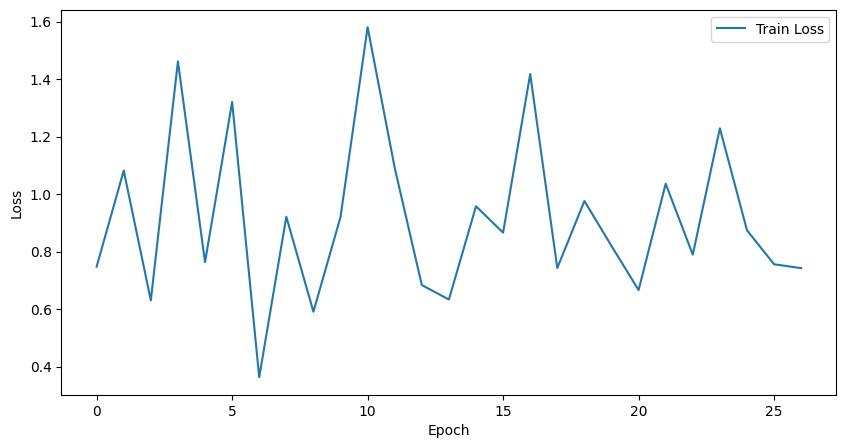

In [33]:
# plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

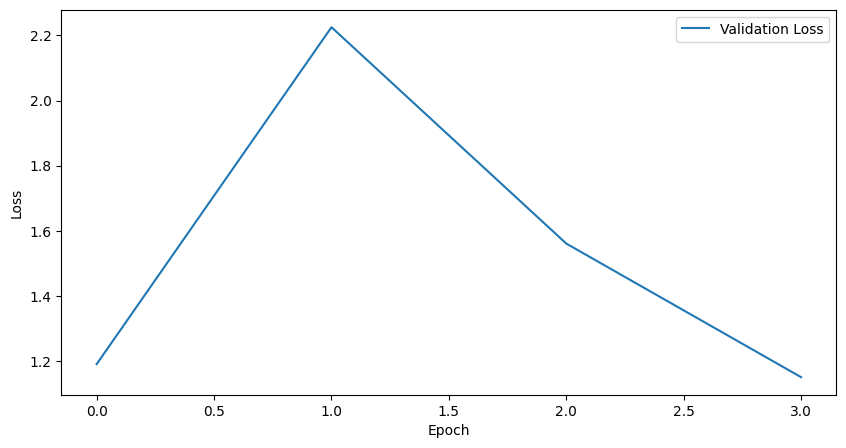

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [35]:
# calculate the accuracy of the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, pred = output.max(1)
        total += target.size(0)
        correct += (pred == target).sum().item()

accuracy = correct / total
print(f"**** accuracy of the model on the test set: {accuracy:.4f} ****")

**** accuracy of the model on the test set: 0.4215 ****


In [36]:
# evaluate the performance of the model on the test set
test_losses = []
actual_alien = []
predicted_alien = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss = loss_fn(output, target)
        test_losses.append(loss.item())
        _, pred = output.max(1)
        actual_alien.extend(target.tolist())
        predicted_alien.extend(pred.tolist())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7859696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Actual: 3, Predicted: 3
Actual: 0, Predicted: 0
Actual: 9, Predicted: 4
Actual: 4, Predicted: 4


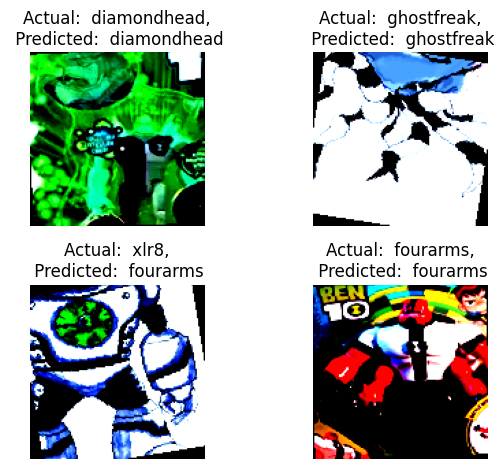

In [47]:
for i in range(4):
    random_index = np.random.randint(0, len(actual_alien))
    print(f"Actual: {actual_alien[random_index]}, Predicted: {predicted_alien[random_index]}")
    plt.subplot(2, 2, i + 1)
    plt.imshow(test_loader.dataset[random_index][0].permute(1, 2, 0))
    plt.title(f"Actual: {full_dataset.classes[actual_alien[random_index]]},\n Predicted: {full_dataset.classes[predicted_alien[random_index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
